In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Step 4
# Now we need to apply non-maximum suppression to thin the edges

def non_maximum_suppression(gradient_image,gradient_angle):
  # first find the dimensions of the image
  image_height,image_width = gradient_image.shape
  
  # as the gradint_angle are in radian unit, convert them to degree unit so that our work will be easier
  gradient_angle = gradient_angle * 180. / np.pi
  
  # creating an output matrix with same size as input image and fill it with zeros
  non_maximum_suppressed_image = np.zeros((image_height,image_width),np.uint8)
  
  
  # Now many angles are in negative, we will shift them to postive angles which will be in the range of 0 to 180 degree
  for i in range(1,image_height-1):
    for j in range(1,image_width-1):
      if gradient_angle[i][j] < 0:
        gradient_angle[i][j] += 180
        
        # Now we will classify the angles into 4 categories
        q = 255
        r = 255
        
        # angle 0
        # when the gradient angle is horizonatally to the spinning circle
        if(0 <= gradient_angle[i][j] < 22.5) or (157.5 <= gradient_angle[i][j] <= 180):
          q = gradient_image[i][j+1]
          r = gradient_image[i][j-1]

        # angle 1
        # when the gradient angle is between 22.5 to 67.5 degree to the spinning circle
        elif(22.5 <= gradient_angle[i][j] < 67.5):
          # Bottom Left
          q = gradient_image[i+1][j-1]
          # Top Right
          r = gradient_image[i-1][j+1]
          
          # angle 2
          # when the gradient angle is vertically to the spinning circle
        elif(67.5 <= gradient_angle[i][j] < 112.5):
          # Bottom
          q = gradient_image[i+1][j]
          # Top
          r = gradient_image[i-1][j]
        
        # angle 3
        # when the gradient angle is between 112.5 to 157.5 degree to the spinning circle
        elif(112.5 <= gradient_angle[i][j] < 157.5):
          # Bottom Right
          q = gradient_image[i+1][j+1]
          # Top Left
          r = gradient_image[i-1][j-1]
  
        # Now we will compare the current pixel value with the two pixels in the gradient direction
        # If it is less we make the intensity to 0 to suppress it
        if(gradient_image[i][j] >= q and gradient_image[i][j] >= r):
          non_maximum_suppressed_image[i][j] = gradient_image[i][j]
        else:
          non_maximum_suppressed_image[i][j] = 0

  return non_maximum_suppressed_image

  

In [13]:
def hysteresis_threshold(image,lowThreshold,highThreshold):
  height,width = image.shape
  thresholded_image = np.zeros((height,width),np.uint8)
  for x in range(1,height-1):
    for y in range(1,width-1):
      if(image[x,y] >= highThreshold):
        thresholded_image[x,y] = 255
      elif(image[x,y] <= lowThreshold):
        thresholded_image[x,y] = 0
      else:
        if((image[x-1,y-1]>=highThreshold) or (image[x-1,y]>=highThreshold) or (image[x-1,y+1]>=highThreshold)
          or (image[x,y-1]>=highThreshold) or (image[x,y+1]>=highThreshold)
          or (image[x+1,y-1]>=highThreshold) or (image[x+1,y]>=highThreshold) or (image[x+1,y+1]>=highThreshold)):
          thresholded_image[x,y] = 255
        else:
          thresholded_image[x,y] = 0
  return thresholded_image

In [14]:
# First read the image
original_image = cv2.imread("../../../data/lena.jpg",cv2.IMREAD_GRAYSCALE)
height,width = original_image.shape

# Step 1 
# Apply gaussian blur to the image
gaussian_blurred_image = cv2.GaussianBlur(original_image,(5,5),1.4)

# Step 2

# Now we define a x-direction sobel filter
sobel_x = np.array([
  [-1,0,1],
  [-2,0,2],
  [-1,0,1]
])

# Now we define a y-direction sobel filter
sobel_y = np.array([
  [1,2,1],
  [0,0,0],
  [-1,-2,-1]
])

# Now we convolve the image with those two filters to find the vector image
gradient_x_sobel = cv2.filter2D(gaussian_blurred_image,cv2.CV_32F,sobel_x)
gradient_y_sobel = cv2.filter2D(gaussian_blurred_image,cv2.CV_32F,sobel_y)

# Step 3


# Now we calculate the magnitude of the sobel vector image to find the edge map or gradient image
gradient_sobel_image = cv2.magnitude(gradient_x_sobel,gradient_y_sobel)
# Normalize the image to 0-255 range
gradient_sobel_image = cv2.normalize(gradient_sobel_image,None,0,255,cv2.NORM_MINMAX).astype(np.uint8)

# Now find the gradient angle at each pixel ( The angle is computed in radian)
theta = np.arctan2(gradient_y_sobel,gradient_x_sobel)
# print(np.rad2deg(theta))


# Do the non-maximum suppression by calling the function
nms_image = non_maximum_suppression(gradient_sobel_image,theta)

# Now apply hysteresis thresholding
thresholded_image =hysteresis_threshold(nms_image,50,80)





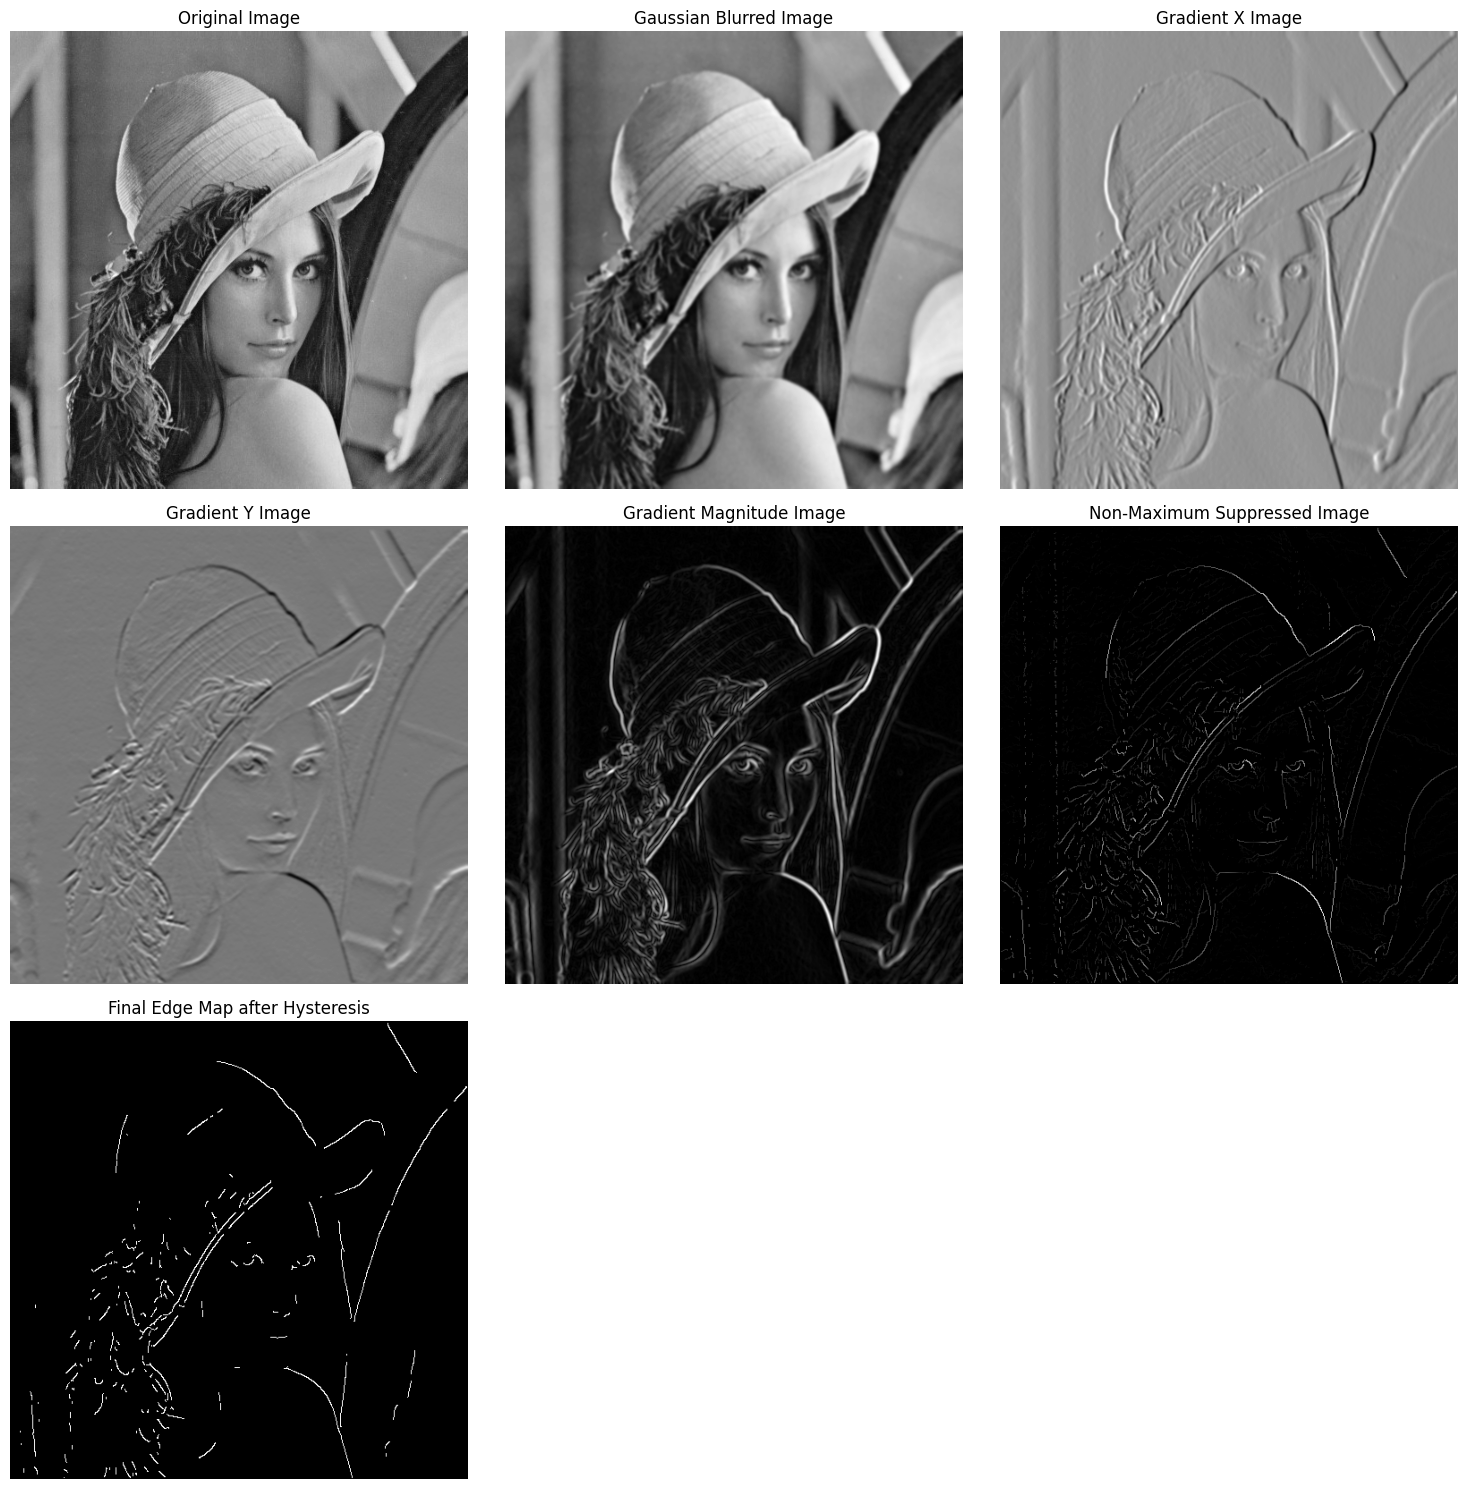

In [15]:
images = [
    (original_image, "Original Image"),
    (gaussian_blurred_image, "Gaussian Blurred Image"),
    (gradient_x_sobel, "Gradient X Image"),
    (gradient_y_sobel, "Gradient Y Image"),
    (gradient_sobel_image, "Gradient Magnitude Image"),
    (nms_image, "Non-Maximum Suppressed Image"),
    (thresholded_image, "Final Edge Map after Hysteresis"),
]

# Make a grid: 3 columns, enough rows for all images
cols = 3
rows = (len(images) + cols - 1) // cols  # ceiling division
fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))

axes = axes.flatten()  # flatten into 1D for easy iteration

for ax, (img, title) in zip(axes, images):
    ax.imshow(img, cmap="gray")
    ax.set_title(title, fontsize=12)
    ax.axis("off")

# Hide any extra axes (if total slots > number of images)
for ax in axes[len(images):]:
    ax.axis("off")

plt.tight_layout()
plt.show()
